# Reddit NLP Classification Project

## Part III: Preprocessing, Modeling, & Interpretation

<img src='./images/pysql.png'>

<font color=white>.</font>

run me! ↓

In [1]:
# css notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

<font color=white>.</font>

#### Executive summary

The goal of this analysis is to classify text posts as either belonging to one subreddit or another, using NLP. 

Success will be evaluated using the model's accuracy score in correctly classifying the posts, with a second goal of trying many models to obtain the highest accuracy score possible.

#### Research Questions

* What preprocessing steps are best for creating a classification model with high accuracy?
* Which classification models and hyperparameters lead to the highest accuracy score?

*Note: Charts generated in plotly have been added as image files in order to support preview rendering in github. Code for these charts can be found in the appendix of this notebook.*

<font color=white>.</font>

## Preprocessing

#### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer
from sklearn.metrics import precision_score, accuracy_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [3]:
learnsql = pd.read_csv('./data/learnsql_clean.csv') #3375 entries
learnpy = pd.read_csv('./data/learnpython_clean.csv') #3396 entries

<font color=white>.</font>

#### Append Datasets, create combined text column

In [4]:
learnboth = learnsql.append(learnpy)
learnboth['combinedtext'] = learnboth['title'] + ' '  + learnboth['selftext']

<font color=white>.</font>

#### Text filters

Filtered out numbers, and converted all text to lowercase

In [5]:
learnboth['combinedtext'] = learnboth['combinedtext'].str.lower().replace('\d+', ' ', regex=True)#.replace('_', '')

Next I used regex to filter out words, from a list of "giveaway" words that I thought would make the class too easy to predict. I went back and added this section, because my models performed a little too well on the first try.

In [6]:
giveaways = ['mysql', 'sql', 'postgres', 'snowflake', 'oracle', 'python', 'anaconda', 'pip install', 'sklearn', 'pandas', 'numpy']
regx = r'({})'.format('|'.join(giveaways))
learnboth['combinedtext'] = learnboth['combinedtext'].str.replace(regx, " ", regex=True).fillna(learnboth['combinedtext'])

<font color=white>.</font>

#### Dummify target column

In [7]:
learnboth['subreddit'] = np.where(learnboth['subreddit']=='learnpython', 1, 0)

In [8]:
learnboth.head(3)

,Unnamed: 0,author,created_utc,id,num_comments,score,selftext,subreddit,title,upvote_ratio,url,combinedtext
0,0,RedishPelican,1648853543,tu3xq6,0,1,MariaDB \[sitename\]&gt; CREATE TABLE users(\n...,0,"MYSQL help, i am trying to create a password c...",1.0,https://www.reddit.com/r/learnSQL/comments/tu3...,"help, i am trying to create a password colum..."
1,1,FreyReddit,1648901466,tuhg74,0,1,How would I find a number of subjects currentl...,0,Test : MySQL,1.0,https://www.reddit.com/r/learnSQL/comments/tuh...,test : how would i find a number of subjects...
2,2,PowerOfTheShell,1648959367,tv0on0,0,1,"Hey guys,\n\nTrying to work out why my SQL que...",0,Query not showing NULL with Left Outer Join,1.0,https://www.reddit.com/r/learnSQL/comments/tv0...,query not showing null with left outer join he...


<font color=white>.</font>

#### Lemmatize combined text

I chose to use lemmatization instead of stemming due to how harsh stemming can be, especially since I'm using data that contains technology-specific words that might be stemmed out of context.

I did notice that my lemmatizer didn't catch some tech-related words like "filtering".

In the table below, you'll see the difference between the original title, and the lemmatized title with "giveaway" words removed.

In [9]:
# You can only run this cell once.

tokenizer = WhitespaceTokenizer()
wnl = WordNetLemmatizer()

def lemmatize(text):
    return ' '.join([wnl.lemmatize(i, pos='v') for i in tokenizer.tokenize(text)])

learnboth['combinedtext'] = learnboth.combinedtext.apply(lambda x: lemmatize(x))

In [10]:
learnboth.loc[:, ['title','combinedtext']].head(10)

,title,combinedtext
0,"MYSQL help, i am trying to create a password c...","help, i be try to create a password column in ..."
1,Test : MySQL,test : how would i find a number of subject cu...
2,Query not showing NULL with Left Outer Join,query not show null with leave outer join hey ...
3,How do i make these columns into one,how do i make these columns into one when the ...
4,How do i display only the most recent order fo...,how do i display only the most recent order fo...
5,8 Best SQL Courses on Coursera,best course on coursera
6,Explain this query in a simpler form. I unders...,explain this query in a simpler form. i unders...
7,Can someone explain what this code is trying t...,can someone explain what this code be try to d...
8,Users cannot see tables in sql management studio,users cannot see table in management studio he...
9,Can someone explain what this SQL Query is try...,can someone explain what this query be try to ...


In [11]:
learnboth.loc[:, ['title','combinedtext']].tail(10)

,title,combinedtext
3386,Amount of string to be printed,amount of string to be print i can get the amo...
3387,Unexpected behavior,"unexpected behavior i'm make my way through "" ..."
3388,Why does Spyder keep changing my working direc...,why do spyder keep change my work directory? i...
3389,How do I access Label Matrix,"how do i access label matrix hi, so i have thi..."
3390,Help with statistics in Pandas,help with statistics in pandas hi! i have a da...
3391,What is the best way for a beginner to learn P...,what be the best way for a beginner to learn ?...
3392,What is command of clearing output in idle pyt...,what be command of clear output in idle shell?...
3393,"Is it possible to achieve this specific, semi-...","be it possible to achieve this specific, semi-..."
3394,How can I use multiple cores to run a big array?,how can i use multiple core to run a big array...
3395,Don't get it - Value is unsubscriptable pylint...,don't get it - value be unsubscriptable pylint...


<font color=white>.</font>

#### Train test split

In [17]:
X = learnboth['combinedtext']
y = learnboth['subreddit']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=404)

<font color=white>.</font>

### Vectorizing Text

#### *CountVectorizer*

In [19]:
cv = CountVectorizer(stop_words='english')
cv.fit(X_train)
X_train_cv = cv.transform(X_train)
X_test_cv = cv.transform(X_test)

In [20]:
X_train_cv=pd.DataFrame(X_train_cv.A, columns=cv.get_feature_names_out())
X_test_cv=pd.DataFrame(X_test_cv.A, columns=cv.get_feature_names_out())

<img src='./images/cv_words.png'>

In [21]:
dcv = pd.DataFrame(X_test_cv.sum().sort_values(ascending=False)).reset_index().iloc[1:, :]
dcv.columns=['word', 'freq']
dcv

,word,freq
1,table,987
2,use,964
3,self,882
4,data,787
5,https,703
...,...,...
22177,getcereal,0
22178,getcenter,0
22179,getcensus,0
22180,getcanvas,0


In [22]:
X_train_cv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5078 entries, 0 to 5077
Columns: 22182 entries, __ to 丹书匚刀巳下呂廾工丿片乚爪冂口尸q尺丂丁凵v山乂y乙
dtypes: int64(22182)
memory usage: 859.4 MB


<font color=white>.</font>

Bonus content: index from a previous version of this countvectorizer that failed to remove special characters

<img src='./images/ಠ_ಠindex.png'>

<font color=white>.</font>

#### *TfidfVectorizer*

The countvectorizer worked well, and my models actually performed fine with it. However I decided to try TfdifVectorizer as well to see which performed better.

TfidfVectorizer operates on the logic that words that are too common in a corpus (entire collection of text) are not helpful for determining patterns, and neither are words that appear too infrequently in a corpus. I set the minimum documents parameter to 2, filtering out words that only appear in a single document, and added a token pattern to remove special characters.

In [23]:
tf = TfidfVectorizer(stop_words='english', min_df=2, max_df=100, max_features=100_000, ngram_range=(1, 1), token_pattern=r'(?u)\b[a-zA-Z0-9][a-zA-Z0-9]+\b' )
tf.fit(X_train)
X_train_tf = tf.transform(X_train)
X_test_tf = tf.transform(X_test)

In [24]:
X_train_tf=pd.DataFrame(X_train_tf.A, columns=tf.get_feature_names_out())
X_test_tf=pd.DataFrame(X_test_tf.A, columns=tf.get_feature_names_out())

<img src='./images/tf_words.png'>

In [25]:
dtf = pd.DataFrame(X_test_tf.sum().sort_values(ascending=False)).reset_index().iloc[1:, :]
dtf.columns=['word', 'freq']
dtf

,word,freq
1,prep,13.000000
2,array,12.232515
3,varchar,10.623317
4,api,10.137725
5,dictionary,9.602918
...,...,...
6832,descriptions,0.000000
6833,modal,0.000000
6834,fives,0.000000
6835,insanely,0.000000


In [26]:
X_train_tf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5078 entries, 0 to 5077
Columns: 6837 entries, aa to zzz
dtypes: float64(6837)
memory usage: 264.9 MB


In [27]:
tfvocab = tf.get_feature_names_out()
cvvocab = cv.get_feature_names_out()

<font color=white>.</font>

## Modeling

For all the models I tried, I used accuracy as a metric to compare, as I care more about the overall percentage of posts I classify correctly (as opposed to being concerned about minimizing either false positives or false negatives in particular.)

#### Baseline model

My baseline model should predict correctly about 50% of the time. 

The first time I tried modeling, the data was slightly imbalanced, so I went back and pulled from the API differently in order to balance classes.

In [28]:
y_test.value_counts(normalize=True)

1    0.501477
0    0.498523
Name: subreddit, dtype: float64

Making a baseline model that predicts 1 (subreddit=learnpython) every time.

In [29]:
from sklearn.dummy import DummyRegressor

baseline = DummyRegressor(strategy='constant', constant=1)
baseline.fit(X_train, y_train)
y_pred = baseline.predict(X_test)

In [30]:
accuracy_score(y_test, y_pred)

0.5014766686355582

In [31]:
balanced_accuracy_score(y_test, y_pred)

0.5

<font color=white>.</font>

#### ***Logistic Regression***

The first model I tried was a simple logistic regression with no normalization. 

Logistic regression has a few limitations, some of which my data don't meet. However, despite this, my basic logistic regression performed fairly well.
* It assumes little or no multicollinearity between independent variables, which is likely not true for this dataset. (High multicollinearity can make a logistic regression model difficult to interpret.)
* It assumes that the independent variables are linearly related to the log odds.
* Results can get out of pocket if you don't scale your data. Since the scale of my data is consistent across all countvectorized text, it wasn't necessary to scale the data in this case.
* It requires a large sample size. Number of features should not exceed rows of data. 



In [528]:
# Seeing if number of features exceed rows of data: they do.

print('number of features from CountVectorizer:', len(cvvocab))
print('number of features from TfdifVectorizer:', len(tfvocab))
print('Number of rows in training set:', len(X_train))
print('Number of rows in test set:', len(X_test))
print('Total number of rows:', len(X))

number of features from CountVectorizer: 22182
number of features from TfdifVectorizer: 6837
Number of rows in training set: 5078
Number of rows in test set: 1693
Total number of rows: 6771


In [36]:
from sklearn.linear_model import LogisticRegression

In [530]:
# instantiate and fit
lr=LogisticRegression(max_iter=1000, penalty='l2', C=0.5)
lr.fit(X_train_cv, y_train)

# predicting test set results
lr_pred = lr.predict(X_test_cv)

# calculating accuracy score
lr.score(X_train_cv, y_train), lr.score(X_test_cv, y_test)

(0.9875935407640803, 0.9049025398700532)

In [531]:
# calculating precision score
precision_score(y_test, lr_pred)

0.9095238095238095

<u>With CountVectorizer</u>: The logistic regression performed well on the first try (99% accuracy in classifying the training set, 95% accuracy in classifying the test set, with no regularization.) Adding L1 or L2 regularization hurt the model's performance.

After removing "giveaway" words, the accuracy of LogReg with CountVectorizer on the test set fell to 89%. Adding L2 regularization (C=0.5) improved the test score to 90.5%.


<u>With TfidfVectorizer</u>: My logistic regression actually performed slightly worse with TfidfVectorizer: 94% accuracy on the training set, 91% accuracy on the testing set. These results did not improve when changing token pattern, decreasing min_df, increasing max_features, adding bigrams, or adding a penalty to the logistic regression.

After removing "giveaway" words, the accuracy of LogReg with TfidfVectorizer fell to 94% for the training set, and 85% for the test set. Adding regularization did not improve the scores for the test set.

<font color=white>.</font>

#### ***KNN***

Moving forward with the rest of my models, I kept the "giveaway" words out of the data.

In [292]:
from sklearn.neighbors import KNeighborsClassifier

In [485]:
# instantiate and fit
kn = KNeighborsClassifier(n_neighbors=2)
kn.fit(X_train_tf, y_train)

# predicting test set results
kn_pred = kn.predict(X_test_tf)

# calculating accuracy score
kn.score(X_train_tf, y_train), kn.score(X_test_tf, y_test)

(0.6169751870815282, 0.5481393975191967)

In [486]:
# calculating precision score
precision_score(y_test, kn_pred)

0.8559322033898306

With CountVectorizer: KNN performed worse than my logistic regression, with an accuracy score of 78% for the training set and 71% for the testing set.

With TfidfVectorizer: These results were worse, with training set scoring 61% accuracy and testing set scoring 54% accuracy. This model barely performed better than the baseline model. Changing hyperparameters did not improve results by much.

<font color=white>.</font>

#### ***Random Forest***

Random forests work by taking many samples with replacement from the original data (bagging), fitting a decision tree on each sample and creating a model, and combining the predictions (ensembling). 

In order to avoid high correlation between models themselves, decision trees select a random subset of features at each split, instead of the "best" features.

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [487]:
# instantiate and fit
rf=RandomForestClassifier(n_estimators=100, random_state=404)
rf.fit(X_train_cv, y_train)

# predicting test set results
rf_pred = rf.predict(X_test_cv)

# calculating accuracy score
rf.score(X_train_cv, y_train), rf.score(X_test_cv, y_test)

(0.999409216226861, 0.9155345540460721)

In [488]:
# calculating precision score
precision_score(y_test, rf_pred)

0.9152941176470588

With CountVectorizer: Random forest classified the training set almost perfectly, with an accuracy score of 99%. On the testing set, it scored slightly better than logistic regression, with an accuracy score of 91%.

With TfidfVectorizer: Random forest classified the training set with an accuracy of 99%, and the test set with an accuracy of 82%.

<font color=white>.</font>

#### ***Naive Bayes***

Naive Bayes is based on the bayes principle, which is used to determine the probability of an outcome given the known probability of a related outcome. 
Bayes principle: **P(A|B) = P(A) * P(B|A)/P(B)**

When used for modeling, naive bayes predicts the probability of belonging to class A, when predictor B has already been provided. It's called "naive" because it makes an assumption that the independent variables are independent of each other.

In [35]:
from sklearn.naive_bayes import MultinomialNB

In [574]:
mnb = MultinomialNB(alpha=1)
mnb.fit(X_train_cv, y_train)
 
# predicting test set results
mnb_pred = mnb.predict(X_test_cv)
 
# calculating accuracy score
mnb.score(X_train_cv, y_train), mnb.score(X_test_cv, y_test)

(0.9385584875935408, 0.9043118724158299)

In [575]:
# calculating precision score
precision_score(y_test,gnb_pred)

0.9304347826086956

My naive bayes did fairly well, scoring 93% accuracy on the training set, vs 90% accuracy on the testing set. This is better than the logistic regression, but slightly worse than the random forest. 

This model had the highest precision score at 93%, meaning that out of all the times it guessed the sub was r/learnpython, it was correct 93% of the time.

<font color=white>.</font>

#### ***XGBoost***

Since the random forest model performed well, I decided to try boosting algorithms.

Boosting algorithms work by learning from their mistakes, and iteratively correcting with each new model. 
If you were to do this by hand, it might look like looking at the places where your model misclassified the target, 
and trying to correct the model to account for those instances.

XGBoost is gradient boosting algorithm, the name is short for "eXtreme Gradient Boosting". The Xtreme part refers to speed enhancements that make XGBoost 10 times faster than regular gradient boosting.

Gradient boosting algorithms also work by learning from their "mistakes", they do this by fitting each improved model to the previous model's residuals.

In [307]:
from xgboost import XGBClassifier

In [559]:
# instantiate and fit
# xgb = XGBClassifier(method = "xgbTree", eta=1, max_depth=2, verbosity=3, n_jobs=4)
# xgb.fit(X_train_tf, y_train)

# predicting test set results
# y_pred = xgb.predict(X_test_cv)

# calculating accuracy score
# xgb.score(X_train_tf, y_train), xgb.score(X_test_tf, y_test)

Unfortunately due to the computational cost of running boosting algorithms, I was not able to get this model to run, even with hyperparameters optimized for speed.

<font color=white>.</font>

#### ***AdaBoost***

AdaBoost in particular works by fitting a sequence of decision trees (or another estimator) on iteratively modified versions of the data. 
After each fit, the algorithm weights each observation based on it's importance in predicting the target variable correctly.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [332]:
# instantiate and fit
abc = AdaBoostClassifier(random_state=404)
abc.fit(X_train_tf, y_train)

# predicting test set results
y_pred = abc.predict(X_test_tf)

# calculating accuracy score
abc.score(X_train_tf, y_train), abc.score(X_test_tf, y_test)

(0.7369042930287515, 0.7253396337861784)

Due to the computational cost of running boosting algorithms, and some computer issues I'm currently having, I chose to use only  TfdifVectorized data for my AdaBoost model since there are fewer features.
It scored 73% accuracy on the training data, and 72% accuracy on the test data.

<font color=white>.</font>

## GridSearch and RandomizedSearchCV

Moving forward I decided to focus on the two models with the highest scores, my random forest and naive bayes models. I also chose to use CountVectorizer instead of TfdifVectorizer, since the scores using CountVectorized data were consistently higher across all models.

I was not able to use XGBoost with this model due to runtime, so instead I focused on the Random Forest and used RandomizedSearchCV to tune hyperparameters.

I chose not to use a pipe for this due to the time and computational cost of searching hyperparameters for both vectorization and  estimators; I also already tried almost all of the settings for CountVectorizer and TfidfVectorizer in the preprocessing stage as I was iteravely improving models.

In [565]:
# Random Forest 

from sklearn.model_selection import RandomizedSearchCV

hyperparams = {
    'n_estimators': [50, 70, 100, 125, 150, 200],
    'min_samples_split': [2, 3, 4],
    'max_features': [3, 40, 70, 150, 300, 'auto'],
    'max_depth': [2, 5, 9, None]
}

rcv = RandomizedSearchCV(rf, hyperparams, cv=5, verbose=1, error_score="raise", n_iter=2)
rcv.fit(X_train_cv, y_train)
rcv.best_params_, rcv.best_score_

Fitting 5 folds for each of 2 candidates, totalling 10 fits


({'n_estimators': 200,
  'min_samples_split': 4,
  'max_features': 'auto',
  'max_depth': 9},
 0.8727853845855474)

In [573]:
# Naive Bayes

hyperparams = {
    'alpha': [0.1, 0.2, 0.3, 0.5, 0.7, 1],
    'fit_prior': [True, False]
}

rcv = GridSearchCV(mnb, hyperparams, cv=5, verbose=1, error_score="raise")
rcv.fit(X_train_cv, y_train)
rcv.best_params_, rcv.best_score_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


({'alpha': 1, 'fit_prior': False}, 0.8920850626430317)

In [576]:
# Logistic Regression

hyperparams = {
    'C': [0.1, 0.2, 0.3, 0.5, 0.7, 1],
}

rcv = GridSearchCV(lr, hyperparams, cv=5, verbose=1, error_score="raise")
rcv.fit(X_train_cv, y_train)
rcv.best_params_, rcv.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


({'C': 0.2}, 0.9021248206043211)

<font color=white>.</font>

#### Voting Classifier

Since many of my models had similar performance, I also tried using VotingClassifier to combine them.

In [38]:
from sklearn.ensemble import VotingClassifier

In [39]:
vc = VotingClassifier(
    [('mnb', MultinomialNB(alpha=1) ),
    ('lr', LogisticRegression(max_iter=1000, penalty='l2', C=0.5) ),
    ('rf', RandomForestClassifier(n_estimators=200, random_state=404, min_samples_split=4) )
]
    ,
    n_jobs=-1
)

In [40]:
vc.fit(X_train_cv, y_train)

VotingClassifier(estimators=[('mnb', MultinomialNB(alpha=1)),
                             ('lr', LogisticRegression(C=0.5, max_iter=1000)),
                             ('rf',
                              RandomForestClassifier(min_samples_split=4,
                                                     n_estimators=200,
                                                     random_state=404))],
                 n_jobs=-1)

In [41]:
# calculate accuracy score

vc.score(X_train_cv, y_train), vc.score(X_test_cv, y_test) 

(0.9923198109491926, 0.9249852333136445)

In [42]:
# calculate precision score

vc_pred = vc.predict(X_test_cv)
precision_score(y_test, vc_pred)

0.9297619047619048

The VotingClassifier outperformed all other models, including the optimized Random Forest, with accuracy in predicting the training data 99.3% of the time, and test data 92.4% of the time. 

The precision score was slightly lower than the precision for the naive bayes model, at 92.8%.

<font color=white>.</font>

## Evaluation

In the end, my highest performing model was the ensemble model that included a random forest, multinomial bayes, and logistic regression, scoring 99.3% accuracy on the training data and 92.4% accuracy on the testing data. 

Although all 3 came close, the random forest was my most successful single model. This model scored a 99% on training data, and a 91.5% on testing data. Ultimately, using Gridsearch and RandomizedSearchCV on the random forest not help much to improve the scores of this model. In fact, it actually decreased the test score by .001%, with the caveat that the model may perform better on different unseen data with these hyperparameters. 

Before removing giveaway words, the logistic regression performed best - probably because words like "postgre" ended up being a dead giveaway that the subreddit was learnsql instead of learnpython (and "flavors" of sql will be mentioned frequently in SQL discussions.)

<font color=white>.</font>

#### Comparison to baseline model

By guessing the majority class every time, the baseline model would correctly classify the text 50.1% of the time. 

In [411]:
baseline = DummyRegressor(strategy='constant', constant=1)
baseline.fit(X_train, y_train)
y_pred = baseline.predict(X_test)
accuracy_score(y_test, y_pred)

0.5014766686355582

<font color=white>.</font>

#### Accuracy and precision

Compared to baseline, the ensemble model (consisting of multinomial bayes, random forest, and logistic regression) performed significantly better. Although it may have been slightly overfit to the training data, it still performed well on the testing data.

In [616]:
cm=confusion_matrix(y_test, vc_pred)
cm

array([[785,  59],
       [ 68, 781]])

[Text(0, 0.5, 'sql'), Text(0, 1.5, 'python')]

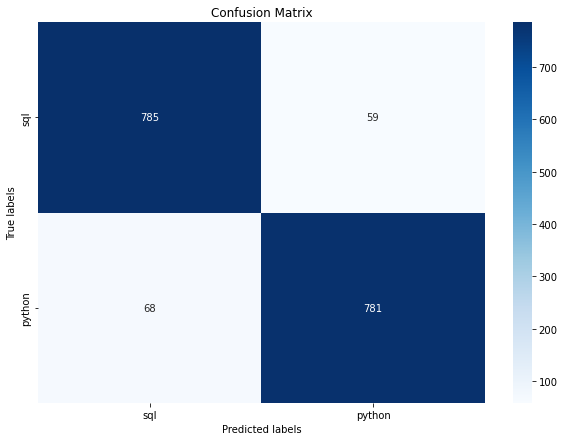

In [617]:
plt.figure(figsize=(10, 7))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues');

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['sql', 'python']); ax.yaxis.set_ticklabels(['sql', 'python'])

<font color=white>.</font>

My accuracy score was 92.4%, meaning that the model correctly classified the text 92.4% of the time. 

This is a large improvement over a bseline score of 50%.

In [583]:
accuracy_score(y_test, vc_pred)

0.9249852333136445

<font color=white>.</font>

My precision score (Number of true positives divided by number of all predicted positives) was 91.3%, meaning that out of all the times I predicted the subreddit to be r/python, I was correct 92.8% of the time. 

Including the naive bayes in my ensemble is probably what improved this score, as the bayes model had the high precision score (93%) compared to ~90% for all the other models.

In [584]:
precision_score(y_test, vc_pred)

0.9297619047619048

In [49]:
misclassifications = pd.DataFrame(X_test.copy())

In [50]:
misclassifications['true class'] = y_test
misclassifications['pred class'] = vc_pred

In [55]:
misclassifications[misclassifications['true class'] != misclassifications['pred class']].tail(50)

,combinedtext,true class,pred class
2840,help with a problem im have an issue with this...,0,1
1404,a free course for a very begginer ? i want to ...,1,0
674,how to populate a database with data from a li...,1,0
1756,need help about backend any course for backend...,1,0
2858,how could i write a application that study the...,1,0
47,certification very simple question and i apolo...,1,0
836,do anyone know which company ask the merge ove...,1,0
1333,try to connect to database. i be get error mes...,1,0
2903,i need some direction for a project. [deleted],0,1
1348,"count comparison in loop within a file, i want...",0,1


<font color=white>.</font>

## Recommendations

For someone else who is looking to solve the same classification problem, I would recommend the following. These are things I did not have time to explore deeper:
    
* Consider trying different libraries when vectorizing text.
* Try using XGBoost on highest-performing models (I was not able to do this due to hardware limitations.)
* Look into tuning hyperparameters when building ensemble methods
* Make sure one user isn't carrying the whole subreddit. Andre380 prolific with his daily SQL challenge, but it lead to a lot of repeated text that wouldn't necessarily generalize to other subreddits.
* Consider finding two subreddits that are more "evenly matched", although the topics of my subreddits were similar, the number of subscribers, overall activity, and number of unique contributers were very different.

Overall this model performs very well for what it is supposed to do: classify some text from reddit as belonging to one subreddit or another. The stakes in this situation are low. Of course, for classification models with higher stakes (medical models, financial models, etc) much more care should be put into tuning, and minimizing the correct metrics!

<font color=white>.</font>

## Appendix: Plotly charts and code

In [432]:
import plotly
import plotly.express as px

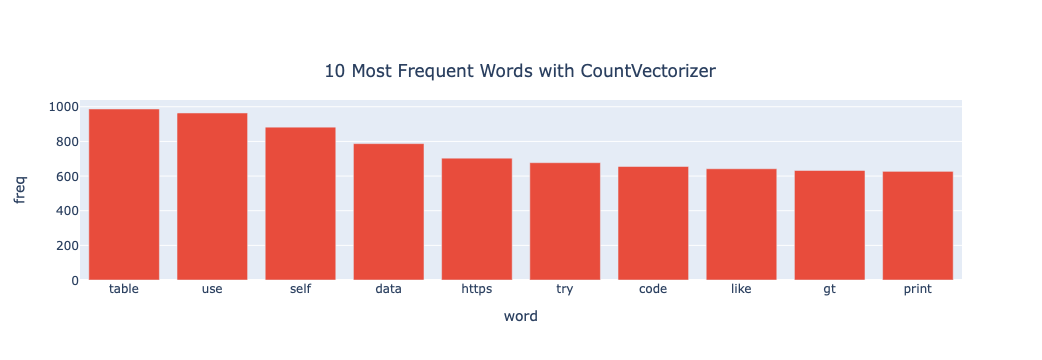

In [592]:
# Top ten common words with CountVectorizer

fig = px.bar(dcv.head(10), 'word', 'freq', title='10 Most Frequent Words with CountVectorizer', color_discrete_sequence=['#E84C3C', '#1C68B9'])
fig.update_layout(title_x=.5, title_y=.82)

In [434]:
dcv

,word,freq
1,table,987
2,use,964
3,self,882
4,data,787
5,https,703
...,...,...
22177,getcereal,0
22178,getcenter,0
22179,getcensus,0
22180,getcanvas,0


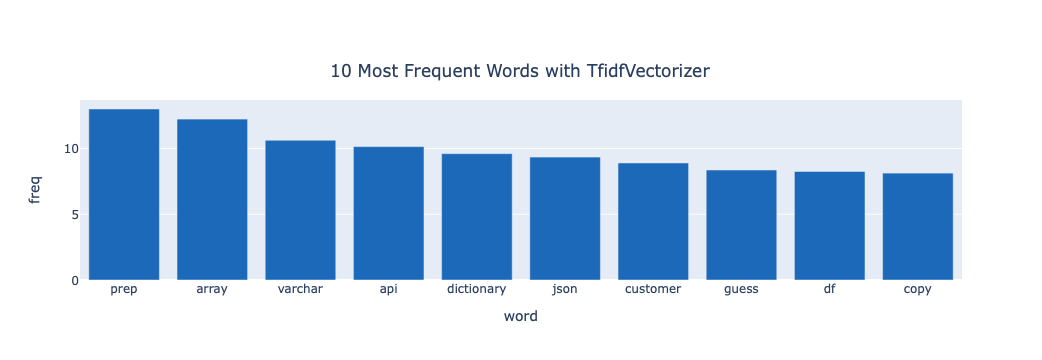

In [591]:
# Top ten common words with TfdifVectorizer

dtf = pd.DataFrame(X_test_tf.sum().sort_values(ascending=False)).reset_index().iloc[1:, :]
dtf.columns=['word', 'freq']

fig = px.bar(dtf.head(10), 'word', 'freq', title='10 Most Frequent Words with TfidfVectorizer',  color_discrete_sequence=['#1C68B9', '#E84C3C'])
fig.update_layout(title_x=.5, title_y=.82)

In [512]:
dtf

,word,freq
1,print,41.802541
2,code,41.745722
3,table,39.450643
4,like,37.794998
5,help,37.668807
...,...,...
9692,rusty,0.000000
9693,diary,0.000000
9694,ryan,0.000000
9695,sa,0.000000
